# Explore Paper Titles and Abstracts

Mucun Tian


In this notebook, you will examine titles and abstracts of papers published in CHI, the premier human-computer interaction research conference, and build a Naive Bayesian Classifier to classify paper year before or after 2000.

The paper data is taken from the [HCI Bibliography](http://hcibib.org).

## Setup

In [1]:
library(tidyverse)
library(tidytext)
library(stringr)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


options

In [2]:
options(repr.matrix.max.rows=10,
        repr.plot.height=5)

## Load Data

In [3]:
chi_papers = read_csv('chi-papers.csv')
head(chi_papers)

Parsed with column specification:
cols(
  id = col_character(),
  year = col_integer(),
  title = col_character(),
  keywords = col_character(),
  abstract = col_character()
)


id,year,title,keywords,abstract
C.CHI.2000.1.1,2000,Unleashed: Web Tablet Integration Into the Home,"Internet appliances, Pen-based computing, Hand-held computers, Ergonomics, Ethnography","To understand how web access from a portable tablet appliance changes the way people use the Internet, MediaOne gave families pen-based tablet computers with a wireless connection to our high-speed data network. We used ethnographic and usability methods to understand how tablets would be integrated into household activities and to define user requirements for such devices. Participants viewed the tablet as conceptually different from a PC. The tablet enabled a high degree of multitasking with household activities, yet flaws in form and function affected use. Results suggest that correctly designed portable Internet appliances will fill a special role in peoples' daily lives, particularly if these devices share information with each other. They will allow spontaneous access to information and communication anywhere."
C.CHI.2000.1.9,2000,Predicting Text Entry Speed on Mobile Phones,"Text entry, Mobile systems, Mobile phones, Keypad input, Human performance modeling, Fitts' law, Digraph frequencies","We present a model for predicting expert text entry rates for several input methods on a 12-key mobile phone keypad. The model includes a movement component based on Fitts' law and a linguistic component based on digraph, or letter-pair, probabilities. Predictions are provided for one-handed thumb and two-handed index finger input. For the traditional multi-press method or the lesser-used two-key method, predicted expert rates vary from about 21 to 27 words per minute (wpm). The relatively new T9 method works with a disambiguating algorithm and inputs each character with a single key press. Predicted expert rates vary from 41 wpm for one-handed thumb input to 46 wpm for two-handed index finger input. These figures are degraded somewhat depending on the user's strategy in coping with less-than-perfect disambiguation. Analyses of these strategies are presented."
C.CHI.2000.1.17,2000,Developing a Context-Aware Electronic Tourist Guide: Some Issues and Experiences,"Mobile computing, Context-awareness, Adaptive hypermedia, User interface design, Evaluation","In this paper, we describe our experiences of developing and evaluating GUIDE, an intelligent electronic tourist guide. The GUIDE system has been built to overcome many of the limitations of the traditional information and navigation tools available to city visitors. For example, group-based tours are inherently inflexible with fixed starting times and fixed durations and (like most guidebooks) are constrained by the need to satisfy the interests of the majority rather than the specific interests of individuals. Following a period of requirements capture, involving experts in the field of tourism, we developed and installed a system for use by visitors to Lancaster. The system combines mobile computing technologies with a wireless infrastructure to present city visitors with information tailored to both their personal and environmental contexts. In this paper we present an evaluation of GUIDE, focusing on the quality of the visitor's experience when using the system."
C.CHI.2000.1.25,2000,Measuring the Allocation of Control in a 6 Degree-of-Freedom Docking Experiment,"Coordination, Interaction techniques, Allocation of control, Virtual docking task, The M-metric, Evaluation methods, Motor control, Input devices, 6 degree-of-freedom control","Coordination definitions and metrics are reviewed from the motor control, biomedical, and human factors literature. This paper presents an alternative measurement called the M-metric, the product of the simultaneity and efficiency of a trajectory, as a means of quantifying allocation of control within a docking task. A 6 degree-of-freedom (DOF) longitudinal virtual docking task experiment was conducted to address how control is allocated across six DOFs, how a

## Conference Stats

Plot the number of papers per year as a line chart.

Group by _year_ and count the number of papers

In [4]:
paper.per.year = chi_papers %>%
    count(year) %>%
    ungroup()
paper.per.year

year,n
1981,78
1982,75
1983,58
1985,41
1986,59
...,...
2013,1009
2014,956
2015,932
2016,1125


We see that there are 33 papers without year information. Actually, year information can be inferred from column _id_ as the first numeric field of _id_ represents _year_. So we can extract _year_ from _id_ and fill up _NA_ rows. For those digits less than 17, they probably represent years after 2000. And for those digits greater than 80 and less than 100, they probably represent years between 1980 and 2000.

In [5]:
chi_papers_year_processed = chi_papers %>%
    mutate(extracted_year = ifelse(is.na(year) & !is.na(id), as.numeric(str_extract(id, "[:digit:]+")), year)) %>%
    mutate(extracted_year = ifelse(extracted_year < 17, extracted_year + 2000, extracted_year)) %>%
    mutate(extracted_year = ifelse(extracted_year < 100, extracted_year + 1900, extracted_year)) %>%
    mutate(year = ifelse(is.na(year) & !is.na(id), extracted_year, year)) %>%
    select(-extracted_year)

In [6]:
chi_papers_year_processed %>%
    count(year) %>%
    ungroup()

year,n
1981,78
1982,75
1983,58
1985,41
1986,59
...,...
2013,1010
2014,959
2015,935
2016,1128


We can see there are still 8 rows without year information. Remove those rows and plot a line chart.

In [7]:
paper.per.year = chi_papers_year_processed %>%
    count(year) %>%
    ungroup() %>%
    filter(!is.na(year))

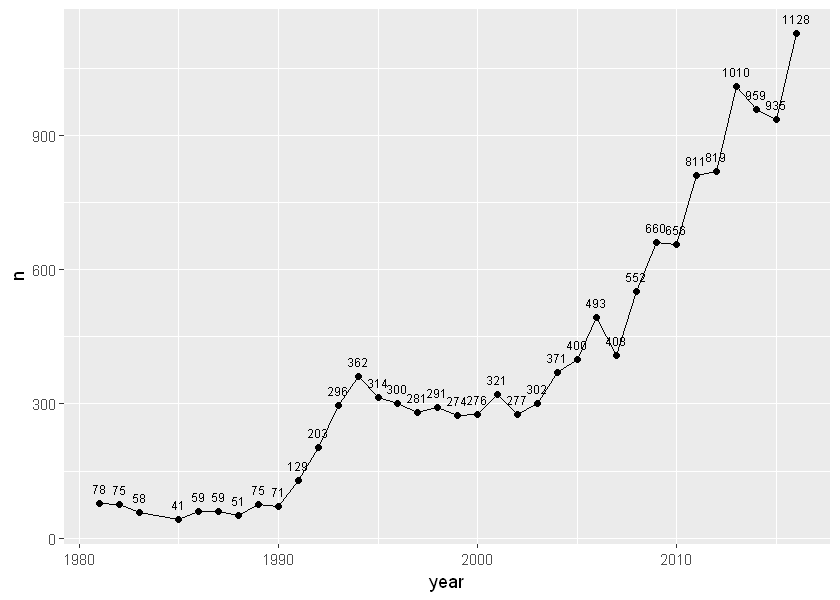

In [8]:
ggplot(paper.per.year) +
    aes(x=year, y=n) +
    geom_line() +
    geom_point() +
    geom_text(mapping=aes(label=n, vjust= -1), 
              size=2.5)

The plot shows that the number of papers increases quickly during two periods: 1990--1994 and 2003--2016.

The tidyr [separate_rows](http://tidyr.tidyverse.org/reference/separate_rows.html) function allows you to split a column containing multiple values into separate rows. This is useful for handling things like the `keywords`, which is a comma-separated list of keywords.  For example:

```r
data %>%
    separate_rows(keywords, sep=',[[:space:]]*')
```

Use that to split the keywords, and then plot the _number of different keywords_ used in each year's conference.  You can compute the number of different keywords by using the dplyr [n_distinct](http://dplyr.tidyverse.org/reference/n_distinct.html) function inside `summarize`.

Remove rows with missing keywords and compute the _number of different keywords_ in each year

In [9]:
distinct.keywords.per.year = chi_papers_year_processed %>%
    filter(!is.na(keywords)) %>%
    separate_rows(keywords, sep=',[[:space:]]*') %>%
    group_by(year) %>%
    summarize(n_distinct_keywords = n_distinct(keywords, na.rm = TRUE)) %>%
    ungroup()
distinct.keywords.per.year

year,n_distinct_keywords
1982,9
1983,3
1986,36
1987,170
1988,158
...,...
2008,15
2009,2220
2010,2174
2011,10


Plot a line chart of the _number of different keywords_ used in each year's conference

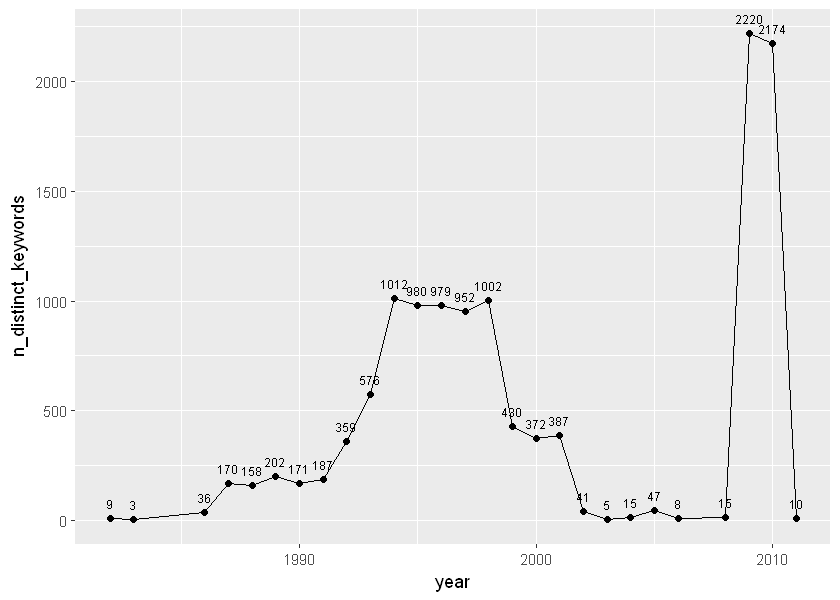

In [10]:
ggplot(distinct.keywords.per.year %>% filter(!is.na(year))) +
    aes(x=year, y=n_distinct_keywords) +
    geom_line() +
    geom_point() +
    geom_text(mapping=aes(label=n_distinct_keywords, vjust= -1), 
              size=2.5)

From the chart above, we can see the counts of keywords are very low in some years, this may be because of the missing keywords. So we can assume that the papers with missing keywords have one unique keyword. 

In [11]:
distinct.keywordsWithNA.per.year = chi_papers_year_processed %>%
    filter(is.na(keywords)) %>%
    group_by(year) %>%
    summarize(n_na=n()) %>%
    ungroup() %>%
    left_join(distinct.keywords.per.year) %>%
    mutate(total=ifelse(is.na(n_distinct_keywords), n_na, n_na + n_distinct_keywords)) %>%
    filter(!is.na(year)) %>%
    select(year, n=total)

Joining, by = "year"


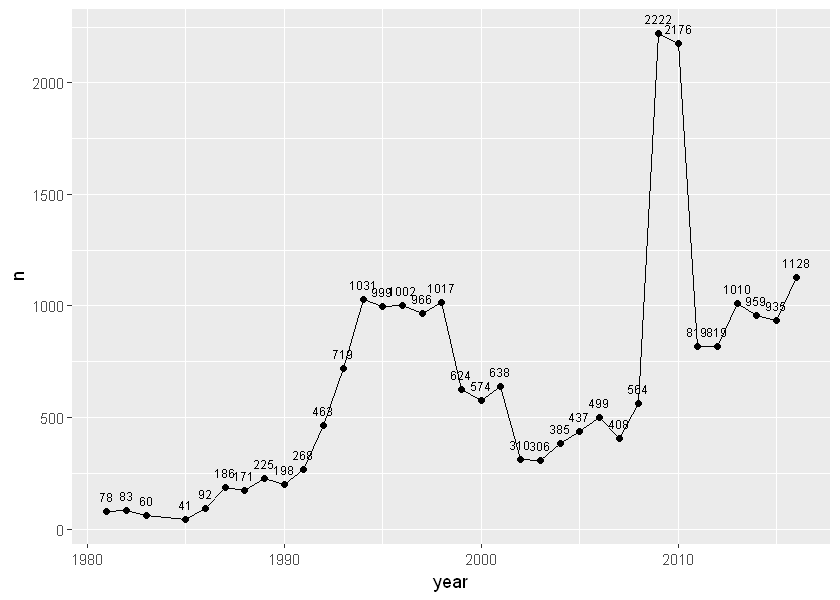

In [12]:
ggplot(distinct.keywordsWithNA.per.year) +
    aes(x=year, y=n) +
    geom_line() +
    geom_point() +
    geom_text(mapping=aes(label=n, vjust= -1), 
              size=2.5)

We can see considering NA values makes a better chart. But this may not be a good processing since it may be more reasonable to replace the number of keywords of each paper with unknown keywords by the average number of keywords per paper in the year which the paper is in. This may also be an improper way, since, in some years, a large portion of papers has no keywords information. In order to make an accurate plot, we can remove entries of those years in which the number of papers with missing keywords is greater than 70% of total papers.

In [13]:
paper.missing.keywords.stats = chi_papers_year_processed %>%
    count(year) %>%
    ungroup() %>%
    rename(totalCount=n) %>%
    left_join(chi_papers_year_processed %>%
              filter(is.na(keywords)) %>%
              count(year) %>%
              ungroup() %>%
              rename(naCount=n)) %>%
    mutate(na_rate = naCount / totalCount)

good.year = paper.missing.keywords.stats %>%
    filter(na_rate < 0.7) %>%
    select(year)

distinct.keywords.per.good.year = distinct.keywords.per.year %>%
    inner_join(good.year) 

Joining, by = "year"
Joining, by = "year"


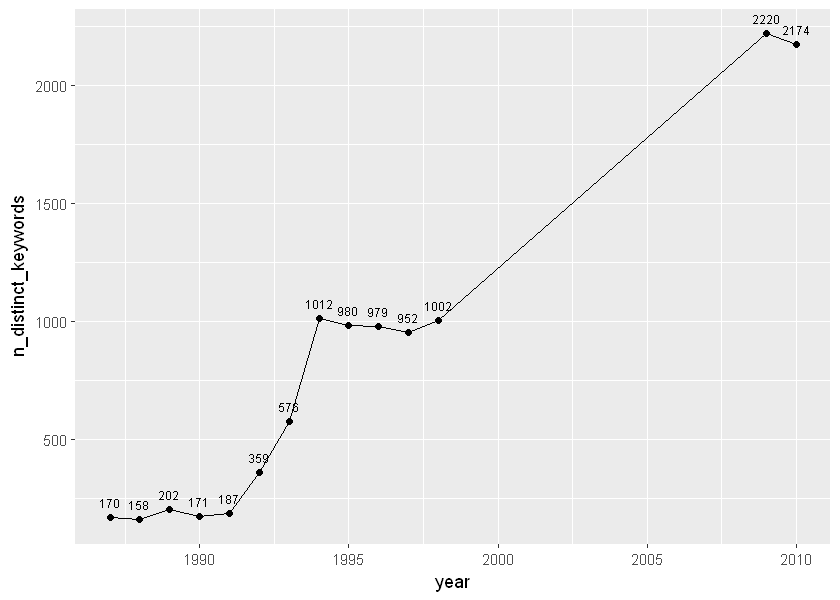

In [14]:
ggplot(distinct.keywords.per.good.year) +
    aes(x=year, y=n_distinct_keywords) +
    geom_line() +
    geom_point() +
    geom_text(mapping=aes(label=n_distinct_keywords, vjust= -1), 
              size=2.5)

From the figure above, we can see that the number of distinct keywords has an increasing trend.

Plot the distribution (histogram) of the number of keywords per paper.

Check _NA_ rows

In [15]:
chi_papers_year_processed %>%
    filter(is.na(id) & is.na(title) & is.na(abstract)) %>%
    nrow()

[1] 0

Rows where all of the _id_, _title_, and _abstract_ are _NA_ do not exist in this data. So we can group by _id_, _title_, _abstract_ since once at least one of these three fields is not _NA_, we can identify an unique paper.

Remove rows with missing keywords, and compute the number of keywords per paper.

In [16]:
num.keywords.per.paper = chi_papers_year_processed %>%
    filter(!is.na(keywords)) %>%
    separate_rows(keywords, sep=',[[:space:]]*') %>%
    group_by(id, year, title, abstract) %>%
    summarize(n_keywords = n())
# num.keywords.per.paper

Plot the distribution
- Set _binwidth_ to 1 to see the histogram for every the _number of keywords_

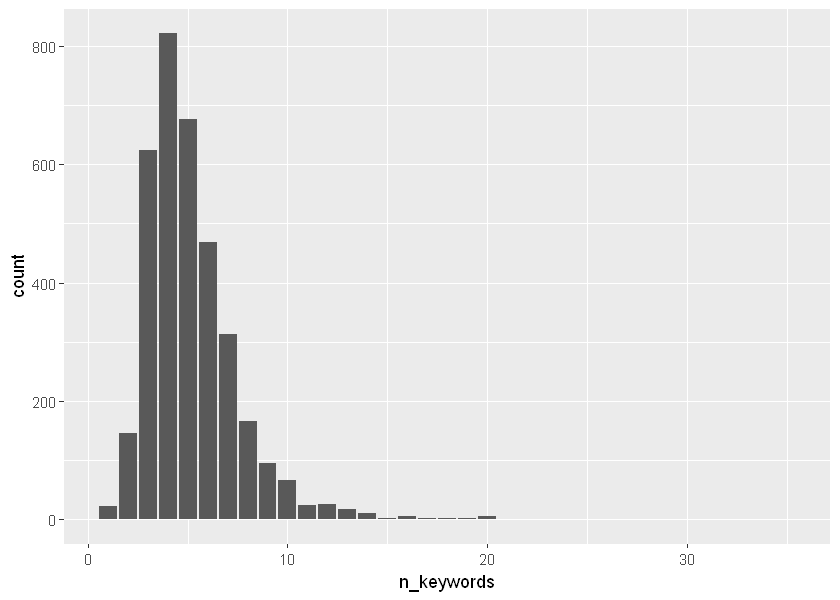

In [17]:
ggplot(num.keywords.per.paper) +
    aes(x=n_keywords) +
    geom_bar()

## Use of Terms

After removing stop words, plot the distribution of the log of word counts in paper **titles**.

First, check the number of rows of missing titles

In [18]:
chi_papers_year_processed %>%
    filter(is.na(title)) %>%
    nrow()

[1] 33

It is only 33 of rows, which is good. We can simply remove them all.

In [19]:
word.counts.per.title = chi_papers_year_processed %>%
    filter(!is.na(title)) %>%
    unnest_tokens(word, title, drop=FALSE) %>%
    anti_join(stop_words) %>%
    count(id, year, title, abstract) %>%
    mutate(log_n = log(n))

Joining, by = "word"


Plot the distribution

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


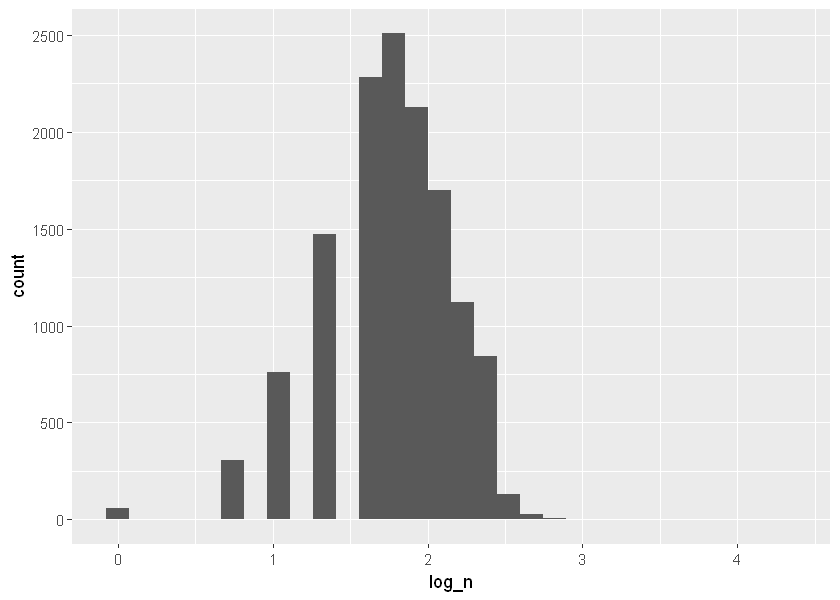

In [20]:
ggplot(word.counts.per.title) +
    aes(x=log_n) +
    geom_histogram() 

From above, we can see the majority of paper titles has about 3 ($e^1$) to 12 ($e^{2.5}$) words

After removing stop words, plot the distribution of the log of word counts in paper **titles and abstracts**.

Compute word counts in abstracts after removing stop words

In [21]:
word.counts.per.abstract = chi_papers_year_processed %>%
    filter(!is.na(abstract)) %>%
    unnest_tokens(word, abstract, drop=FALSE) %>%
    anti_join(stop_words) %>%
    count(id, year, title, abstract) %>%
    ungroup() %>%
    rename(wordCount_abstract=n)

Joining, by = "word"


Full join with word counts in titles since either the title or abstract of a paper can be missing value. And we can treat _NA_ vaules as _zero_. 

In [22]:
word.counts.title.abstract = word.counts.per.title %>%
    select(id, year, title, abstract, wordCount_title=n) %>%
    full_join(word.counts.per.abstract) %>%
    mutate(wordCount_title=ifelse(is.na(wordCount_title), 0, wordCount_title),
           wordCount_abstract=ifelse(is.na(wordCount_abstract), 0, wordCount_abstract),
           wordCount = wordCount_title + wordCount_abstract) %>%
    select(-one_of(c('wordCount_title', 'wordCount_abstract'))) %>%
    mutate(log_n=log(wordCount))

Joining, by = c("id", "year", "title", "abstract")


Plot the histogram

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


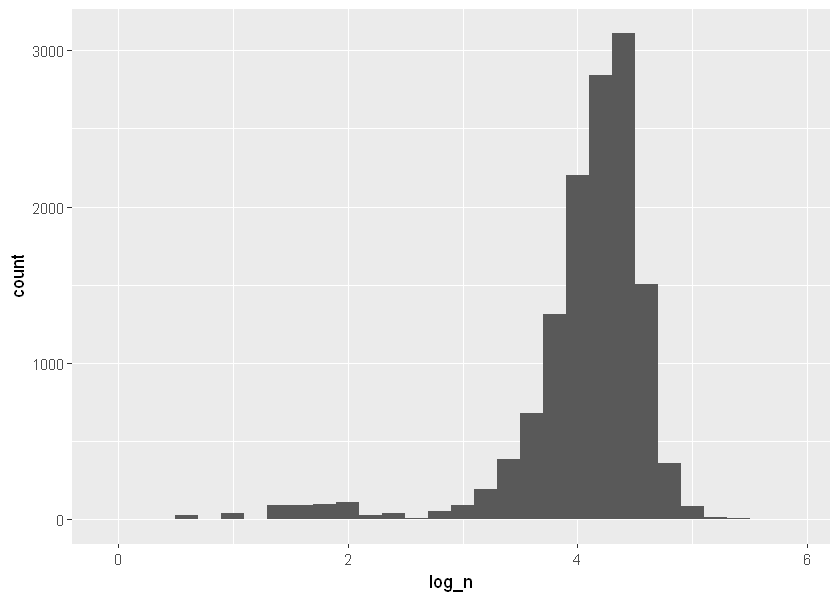

In [23]:
ggplot(word.counts.title.abstract) +
    aes(x=log_n) +
    geom_histogram()

From the figure above, it shows that the most papers have about 20 ($e^3$) to 150 ($e^5$) of words in title and abstract.

What are the 10 most common words (after removing stop words) in titles in 1990?

Tokenize words in titles and anti join stop words

In [24]:
word.title.1990 = chi_papers_year_processed %>%
    filter(!is.na(title) & year==1990) %>%
    unnest_tokens(word, title, drop=FALSE) %>%
    anti_join(stop_words)

Joining, by = "word"


Count words and rank by counts

In [25]:
word.title.1990 %>%
    count(word, sort=TRUE) %>%
    ungroup() %>%
    mutate(lag_n=lag(n, default=max(n)),
           rank = cumsum(n!=lag_n) + 1) %>%
    head(10)

word,n,lag_n,rank
interface,12,12,1
design,10,12,2
computer,8,10,3
systems,8,8,3
user,8,8,3
human,7,8,4
interaction,7,7,4
interfaces,6,7,5
analysis,5,6,6
research,5,5,6


We can see top 10 words are the words before rank 6 and with at least 5 co-occurrence. It has same results when considering words occurrence in distinct titles.

In [26]:
word.title.1990 %>%
    count(word, sort=TRUE) %>%
    ungroup() %>%
    filter(n > 4) %>%
    select(word)

word
interface
design
computer
systems
user
human
interaction
interfaces
analysis
research


The 10 most common words in titles in 1990 are **interface, design, computer, systems, user, human, interaction, interfaces, analysis, research**

What are the 10 most common words (after removing stop words) in titles in 2015?

Tokenize words and remove stop words

In [27]:
word.title.2015 = chi_papers_year_processed %>%
    filter(!is.na(title) & year==2015) %>%
    unnest_tokens(word, title, drop=FALSE) %>%
    anti_join(stop_words)

Joining, by = "word"


When it comes to the 10 most common words, we can only consider the 10 most common words appearing in different titles. It means duplicate words in one title can only be counted once. 

In [28]:
word.title.2015 %>%
    distinct() %>%
    count(word, sort=TRUE) %>%
    ungroup() %>%
    mutate(lag_n=lag(n, default=max(n)),
           rank = cumsum(n!=lag_n) + 1) %>%
    head(10)

word,n,lag_n,rank
design,81,81,1
interaction,72,81,2
mobile,50,72,3
interactive,49,50,4
user,44,49,5
designing,43,44,6
based,39,43,7
social,39,39,7
exploring,36,39,8
data,35,36,9


Top 10 words are the words before rank 9 and with at least 35 co-occurrence.

In [29]:
word.title.2015 %>%
    distinct() %>%
    count(word, sort=TRUE) %>%
    ungroup() %>%
    filter(n > 34) %>%
    select(word)

word
design
interaction
mobile
interactive
user
...
based
social
exploring
data


The 10 most common words in titles in 1990 are **design, interaction, mobile, interactive, user, designing, based, social, exploring, data, hci**

## Basic Text Prediction

Suppose we wanted to predict, using the words in a paper title, whether it was written after 2000 or not.

One way to look at this is to look at the probability of different words appearing in pre-2000 papers and newer papers: that is, for each word, we compute $P(w|R)$ and $P(w|\neg R)$, where $R$ means the paper is recent and $\neg R$ means it is not recent.

With these computations, and the set $W$ of words used in a paper title, we can compute whether the paper is more likely to be recent or not, by computing the following:

$$\begin{align*}
P(R|W) = P(R) \prod_{w \in W} P(w|R) \\
P(\neg R|W) = P(\neg R) \prod_{w \in W} P(w|\neg R)
\end{align*}$$

So we are going to build a small classifier that uses these probabilities, and classifies a paper as being recent if $P(R|W) > P(\neg R|W)$.

First, split articles into training and test articles; we also only need titles.

In [30]:
summaries = chi_papers_year_processed %>%
    select(id, year, title) %>%
    mutate(recent = year >= 2000) %>%
    filter(!is.na(title) & !is.na(year))
test_summaries = summaries %>% sample_frac(0.1)
train_summaries = summaries %>% anti_join(test_summaries)

Joining, by = c("id", "year", "title", "recent")


Now, compute for recent and non-recent articles in the training data, the probability of a word appearing in recent and non-recent articles.  This is the term frequency of the word over all articles.

The result should be a data frame that has three columns: `word`, the word; `new`, the probability of that word appearing in a new article; and `old`, the probability of that word appearing in an old article.  This data frame will be your ‘model’.

I recommend the following approach:

1. Compute term frequencies by recency (using `group_by`, and `summarize` or `count`; if you use `summarize`, you will probably need to do a couple of groupings and a grouped `mutate` to convert the counts into probabilities: group by recent & word, count, group by recent, divide counts by the sum of counts)
2. `spread` the results into a wider table

Build the model without stop words removal.

In [31]:
word.recency.prob = train_summaries %>%
    unnest_tokens(word, title, drop=FALSE) %>%
#     anti_join(stop_words) %>%
    group_by(word, recent) %>%
    summarize(count=n()) %>%
    ungroup() %>%
    group_by(recent) %>%
    mutate(prob = count / sum(count)) %>%
    ungroup() %>%
    select(word, recent, prob)

Spread the results by `recent` to build the model

In [32]:
model = word.recency.prob %>%
    spread(recent, prob, fill=0) %>%
    select(word, new='TRUE', old='FALSE')
model

word,new,old
0,0.000000e+00,4.420671e-05
00,0.000000e+00,4.420671e-05
08,3.356643e-05,0.000000e+00
1,7.832168e-05,8.841342e-05
10,3.356643e-05,8.841342e-05
...,...,...
zoozbeat,1.118881e-05,0
zpots,1.118881e-05,0
zsense,1.118881e-05,0
zwerm,1.118881e-05,0


Compute, for each test article, the probability of it being recent, and the probability of it being old, using the formulas above.  You will need to tokenize the titles, join with the model (to get probabilities), and multiply the probabilities (using `prod`, it works like `sum`).  Assume $P(R) = P(\neg R) = 0.5$.

In [33]:
p_r = 0.5
test.preds = test_summaries %>%
    unnest_tokens(word, title, drop=FALSE) %>%
#     anti_join(stop_words) %>%
    left_join(model) %>%
    group_by(id, year, title) %>%
    mutate(new = p_r*prod(new, na.rm=TRUE),
           old = (1 - p_r)*prod(old, na.rm=TRUE)) %>%
    ungroup() %>%
    mutate(pred = new > old)

Joining, by = "word"


Classify each test article as 'recent' if $P(R|W) > P(\neg R|W)$.  What is the accuracy (fraction of articles classified correctly) of your classifier?

In [34]:
mean(test.preds$recent==test.preds$pred)

[1] 0.8054691

Congrats! You have built a naive Bayes classifier.